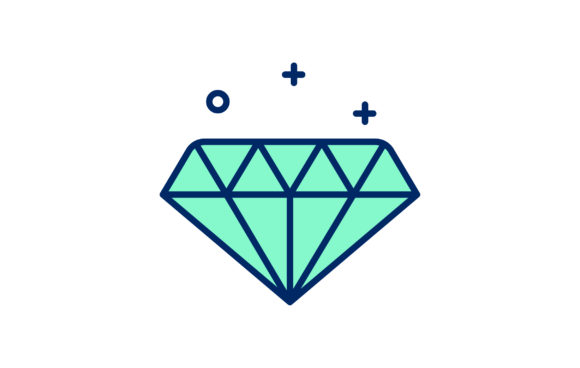

In [258]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image
from pandas_profiling import ProfileReport
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-pastel')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.compose import ColumnTransformer



Image('diamond1.jpg')

# Problem definition

> You are hired by a company Gem Stones co ltd, which is a cubic zirconia manufacturer. You are provided with the dataset containing the prices and other attributes of almost 27,000 cubic zirconia (which is an inexpensive diamond alternative with many of the same qualities as a diamond). The company is earning different profits on different prize slots. You have to help the company in predicting the price for the stone on the basis of the details given in the dataset so it can distinguish between higher profitable stones and lower profitable stones so as to have a better profit share. Also, provide them with the best 5 attributes that are most important.

# What kind of data do we have?

> This data was sourced from [Kaggle.](https://www.kaggle.com/datasets/colearninglounge/gemstone-price-prediction)

# Success Definition

> Minimizing the error of the prediction. 

# Feature Dictionary

> **Carat**  
>>Carat weight of the cubic zirconia.

> **Cut**
>>Describe the cut quality of the cubic zirconia. Quality is increasing order Fair, Good, Very Good, Premium, Ideal.

> **Color**
>>Colour of the cubic zirconia.With D being the best and J the worst.

> **Clarity**
>>Cubic zirconia Clarity refers to the absence of the Inclusions and Blemishes. (In order from Best to Worst, FL = flawless, I3= level 3 inclusions) FL, IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3

> **Depth**
>>The Height of a cubic zirconia, measured from the Culet to the table, divided by its average Girdle Diameter.

> **Table**
>>The Width of the cubic zirconia's Table expressed as a Percentage of its Average Diameter.

> **Price**
>>The Price of the cubic zirconia.

> **X**
>>Length of the cubic zirconia in mm.

> **Y**
>>Width of the cubic zirconia in mm.

> **Z**
>>Height of the cubic zirconia in mm.

# Feature Exploration and Data Anlysis

In [259]:
data = pd.read_csv('cubic_zirconia.csv')

In [260]:
profile = ProfileReport(data, minimal=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [261]:
#Quick overview of the data we are working with

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26967 entries, 0 to 26966
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  26967 non-null  int64  
 1   carat       26967 non-null  float64
 2   cut         26967 non-null  object 
 3   color       26967 non-null  object 
 4   clarity     26967 non-null  object 
 5   depth       26270 non-null  float64
 6   table       26967 non-null  float64
 7   x           26967 non-null  float64
 8   y           26967 non-null  float64
 9   z           26967 non-null  float64
 10  price       26967 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 2.3+ MB


In [262]:
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


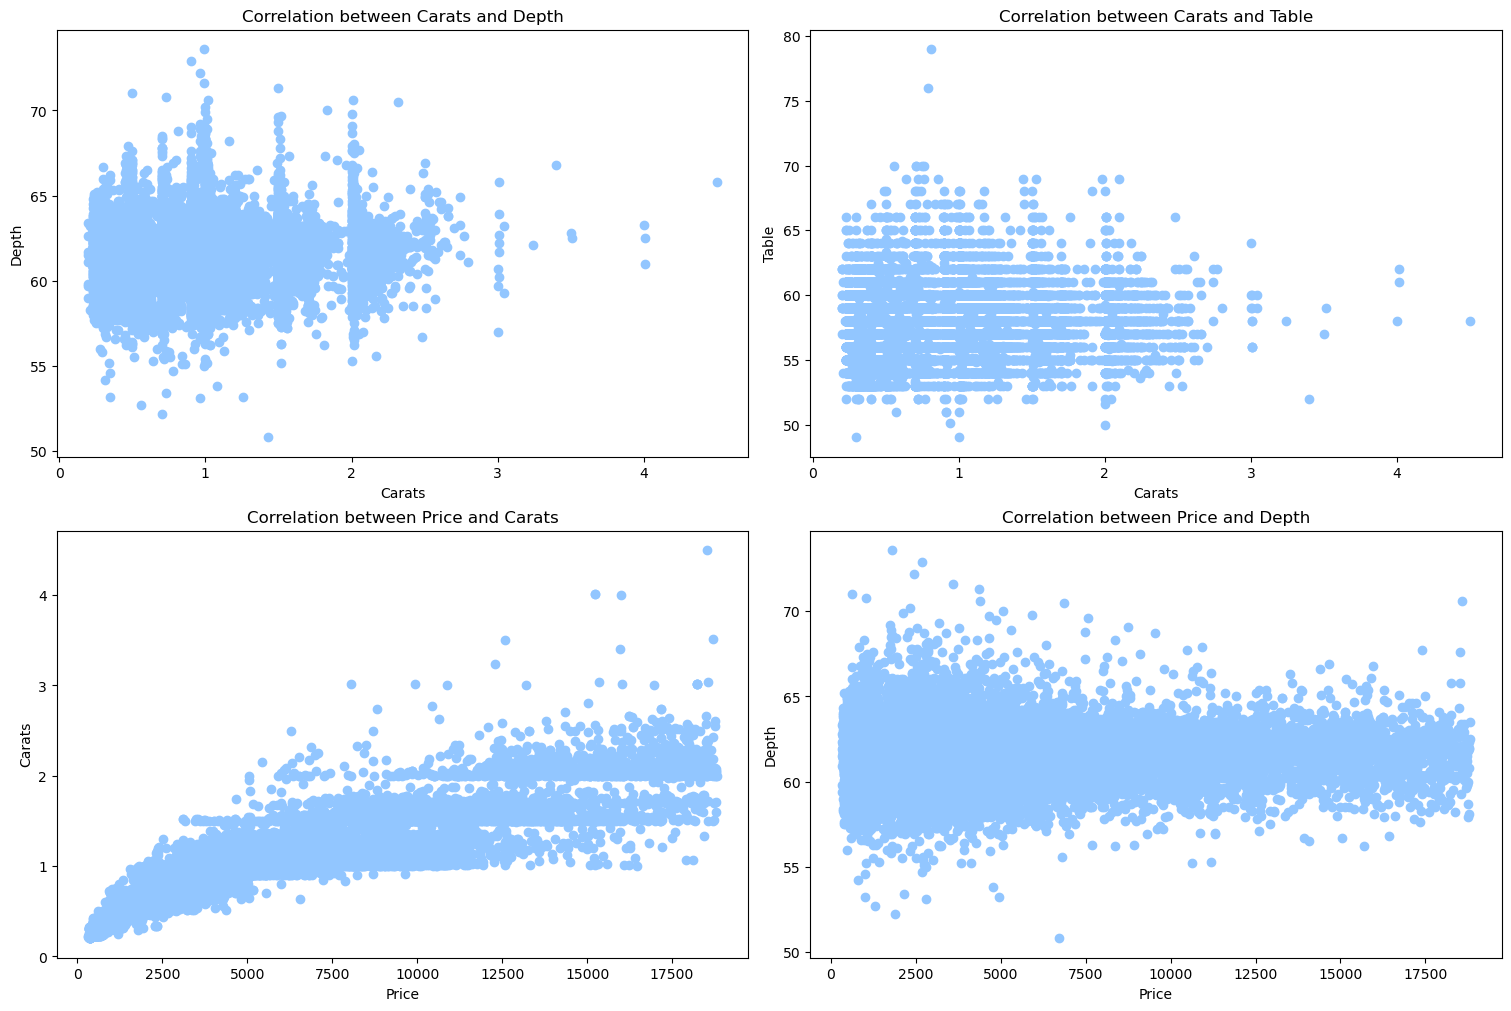

In [263]:
#Checking the correlation between interesting features.

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), layout='constrained')

ax[0,0].scatter(data['carat'], data['depth'])
ax[0,0].set(title = 'Correlation between Carats and Depth', xlabel='Carats', ylabel='Depth');

ax[0,1].scatter(data['carat'], data['table'])
ax[0,1].set(title = 'Correlation between Carats and Table', xlabel='Carats', ylabel='Table');

ax[1,0].scatter(data['price'], data['carat'])
ax[1,0].set(title = 'Correlation between Price and Carats', xlabel='Price', ylabel='Carats');

ax[1,1].scatter(data['price'], data['depth'])
ax[1,1].set(title = 'Correlation between Price and Depth', xlabel='Price', ylabel='Depth');

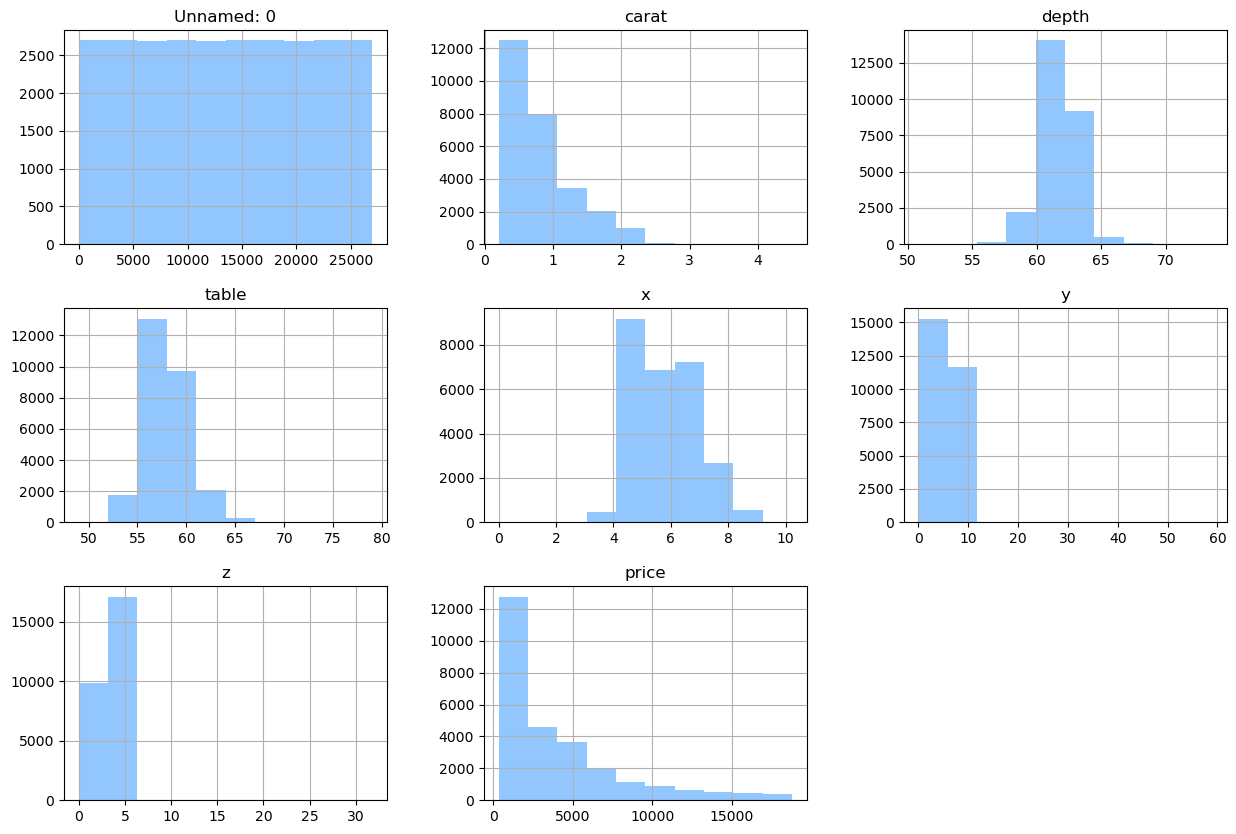

In [264]:
#Checking the distribution of the data

data.hist(figsize=(15,10));

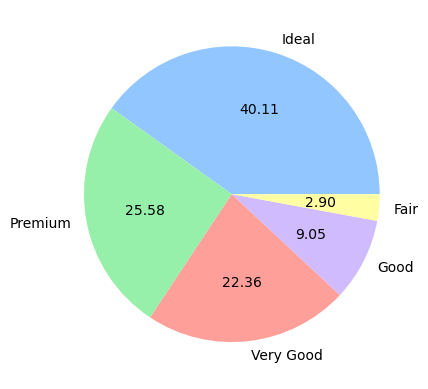

In [265]:
#Checking the distribution of the cut quality

plt.pie(data['cut'].value_counts(), labels=data['cut'].unique(), autopct='%.02f');

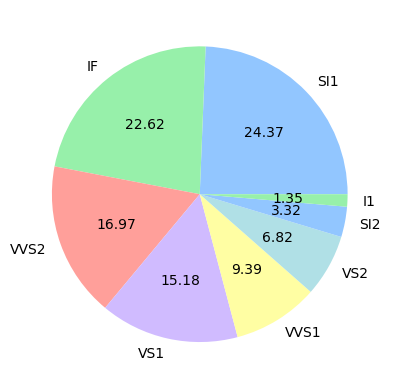

In [266]:
#Checking the distribution of the clarity

plt.pie(data['clarity'].value_counts(), labels=data['clarity'].unique(), autopct='%.02f');

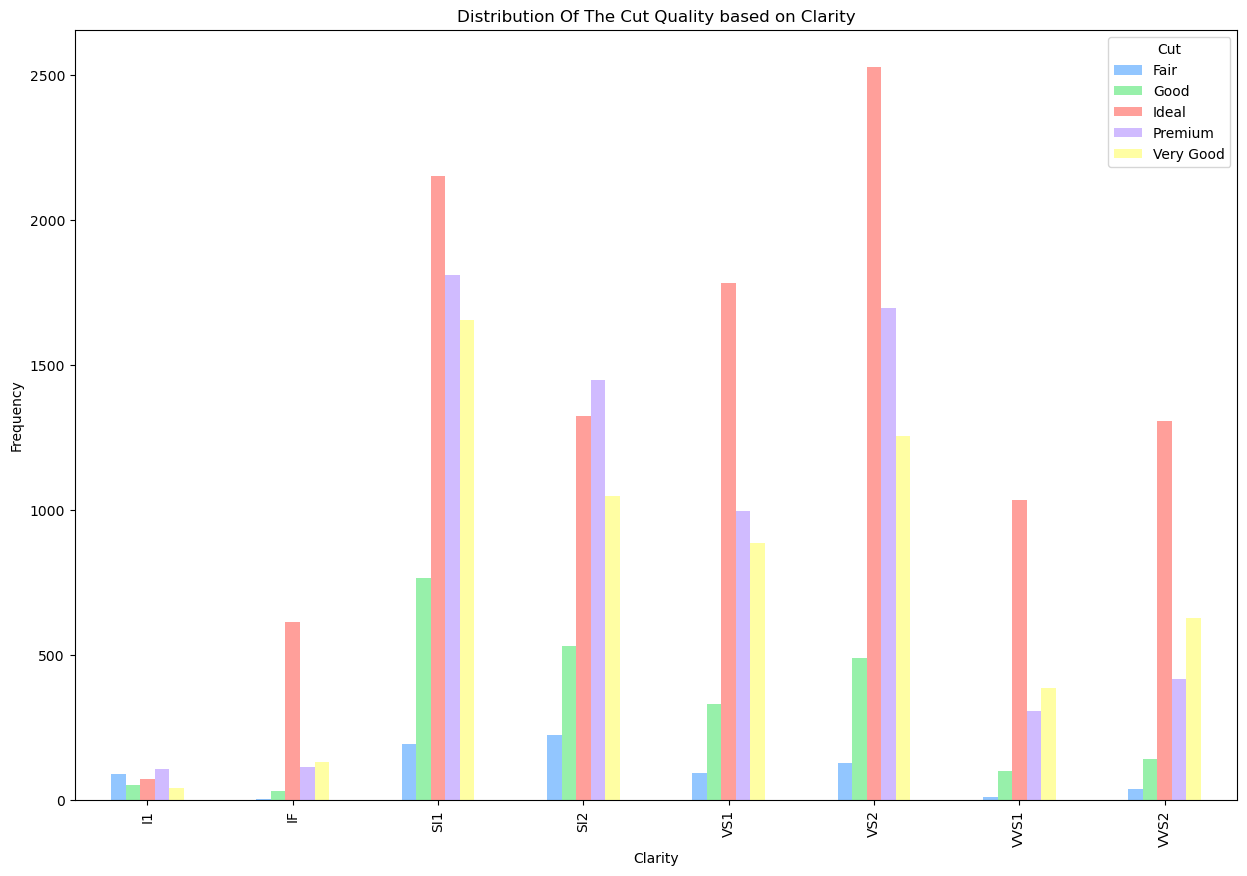

In [267]:
pd.crosstab(data['clarity'], data['cut']).plot(kind='bar', figsize=(15,10));
plt.title('Distribution Of The Cut Quality based on Clarity')
plt.xlabel('Clarity')
plt.ylabel('Frequency')
plt.legend(title='Cut');

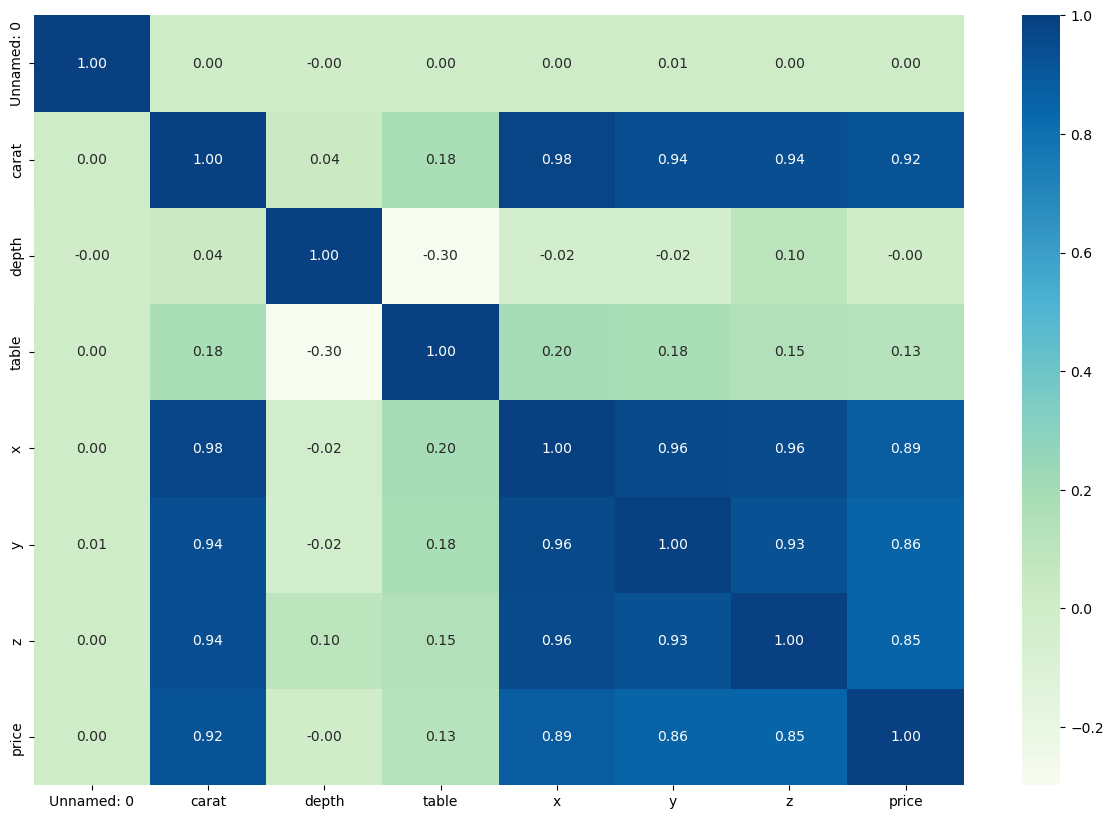

In [268]:
#Plotting a correlation matrix

correlation_matrix = data.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='GnBu', fmt='.2f')

> We can see that the dimensions of the diamond (x,y,z) and the carat (weight) are very strongly correlated to the price

# Tidying up and pre-processing the data

In [269]:
#The column "Unnamed: 0" seems to have no correlation with anything, we will check what it contains.

data['Unnamed: 0'][:100].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [270]:
#It seems that it is a column of indexes, we will be removing it from the data

data.drop('Unnamed: 0', axis = 1, inplace=True)

In [271]:
#Data without the "Unnamed:0" column

data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


In [272]:
#Checking for missing values

data.isna().sum()

carat        0
cut          0
color        0
clarity      0
depth      697
table        0
x            0
y            0
z            0
price        0
dtype: int64

In [273]:
#Checking the datatype, mean and median of the feature with missing values

data['depth'].dtype, data['depth'].mean(), data['depth'].median()

(dtype('float64'), 61.74514655500572, 61.8)

In [274]:
#Copying the DataFrame for redundancy

data_copy = data.copy()

In [275]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26967 entries, 0 to 26966
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    26967 non-null  float64
 1   cut      26967 non-null  object 
 2   color    26967 non-null  object 
 3   clarity  26967 non-null  object 
 4   depth    26270 non-null  float64
 5   table    26967 non-null  float64
 6   x        26967 non-null  float64
 7   y        26967 non-null  float64
 8   z        26967 non-null  float64
 9   price    26967 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 2.1+ MB


In [276]:
# Splitting the data

X = data_copy.drop('price', axis=1)
y = data_copy['price']

In [277]:
#Filling up the missing data

X['depth'].fillna(X['depth'].median(), inplace=True)

In [278]:
X.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

In [279]:
#Transforming the string data
np.random.seed(42)

enc = OrdinalEncoder()
enc.fit_transform(data)


categorical_features = ["cut", "color", "clarity"]

transformer = ColumnTransformer([("enc", enc, categorical_features)], remainder="passthrough")
transformed_data = transformer.fit_transform(X)
data_t = pd.DataFrame(transformed_data)
data_t.head()

,0,1,2,3,4,5,6,7,8
0,2.0,1.0,2.0,0.30,62.1,58.0,4.27,4.29,2.66
1,3.0,3.0,1.0,0.33,60.8,58.0,4.42,4.46,2.70
2,4.0,1.0,7.0,0.90,62.2,60.0,6.04,6.12,3.78
3,2.0,2.0,4.0,0.42,61.6,56.0,4.82,4.80,2.96
4,2.0,2.0,6.0,0.31,60.4,59.0,4.35,4.43,2.65


In [280]:
# Normalizing the data
np.random.seed(42)

X = normalize(data_t)

In [281]:
#Finally splitting the data into train and test sets
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2)

# Modelling

In [282]:
#Preparing a mass testing function

def mass_test(X_train, X_test, y_train, y_test):
    """
    Mass testing models, to check which ones fit the best
    so that we can tune them further.
    """
    
    lin_reg = LinearRegression(n_jobs=-1, positive=True, fit_intercept=False)
    
    catb = CatBoostRegressor(silent=True)
    
    rfr = RandomForestRegressor()
    
    lin_reg.fit(X_train, y_train), catb.fit(X_train, y_train), rfr.fit(X_train, y_train)
    
    results = {
        "Linear Regression Score: ": str(round(lin_reg.score(X_test,y_test)*100, 2))+'%',
        "Catboost Regressor Score: ": str(round(catb.score(X_test,y_test)*100, 2))+'%',
        "Random Forest Regressor: ": str(round(rfr.score(X_test,y_test)*100, 2))+'%'
    }
    
    return results
    

In [283]:
np.random.seed(42)

mass_test(X_train, X_test, y_train, y_test)

{'Linear Regression Score: ': '76.57%',
 'Catboost Regressor Score: ': '97.51%',
 'Random Forest Regressor: ': '97.05%'}

> Catboost Regressor and Random Forest Regressor have the best scores, thus we will try to tune them further

In [284]:
%%time

grid_catb = {
    'depth': [5,8,10],
    'learning_rate': [0.05, 0.1, 0.2],
    'iterations':[100, 120, 140]
}

grid_rfr = {
    'max_depth':[10,20,30],
    'n_estimators':[800, 2000, 3000],
    'min_samples_split': [2,5]
}


grid_catb = GridSearchCV(CatBoostRegressor(silent=True), param_grid=grid_catb,cv=5,verbose=True, n_jobs=-1)
grid_rfr = GridSearchCV(RandomForestRegressor(), param_grid=grid_rfr,cv=5,verbose=True, n_jobs=-1)

grid_catb.fit(X_train, y_train)
grid_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: user 56.2 s, sys: 1.33 s, total: 57.5 s
Wall time: 13min 10s


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30], 'min_samples_split': [2, 5],
                         'n_estimators': [800, 2000, 3000]},
             verbose=True)

In [285]:
grid_catb.best_params_

{'depth': 5, 'iterations': 140, 'learning_rate': 0.2}

In [286]:
grid_rfr.best_params_

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 2000}

In [287]:
ideal_catb = CatBoostRegressor(depth=8, iterations=100, learning_rate=0.05)
ideal_rfr = RandomForestRegressor(max_depth=30, max_features='auto', min_samples_split=2, n_estimators=800, verbose=True)

In [288]:
ideal_catb.fit(X_train, y_train, silent=True)
ideal_rfr.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   22.6s finished


RandomForestRegressor(max_depth=30, max_features='auto', n_estimators=800,
                      verbose=True)

In [289]:
ideal_catb.score(X_test, y_test)

0.9646803029042791

In [290]:
ideal_rfr.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.1s finished


0.9709173812461884

In [291]:
catb = CatBoostRegressor(silent=True)
rfr = RandomForestRegressor(verbose=True)

catb.fit(X_train, y_train)
rfr.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished


RandomForestRegressor(verbose=True)

>Unfortunately the 'ideal' models found by GridSearch yiled lesser results than the default models, with CatBoost being the winner, we will continue with evaluating it.

# Evaluating the model

In [292]:
def evaluate_model(model):
    
    true_labels = y_test
    preds = model.predict(X_test)
    
    evaluation = {
        "R2 Score: ": str(round(r2_score(true_labels, preds)*100, 2))+'%',
        "Mean Absolute Error": str(round(mean_absolute_error(true_labels, preds), 2)),
        "Mean Squared Log Error": str(round(mean_squared_log_error(true_labels, preds), 2))
    }
    
    return evaluation

In [293]:
evaluate_model(catb)

{'R2 Score: ': '97.51%',
 'Mean Absolute Error': '323.59',
 'Mean Squared Log Error': '0.02'}

# Feature Importance

In [294]:
#Creating a function that plots feature importances

def plot_features (columns, importances, n=20):
    df = (pd.DataFrame({'features': columns,
                       "feature_importances": importances}).sort_values("feature_importances", ascending=False).reset_index(drop=True))
    
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

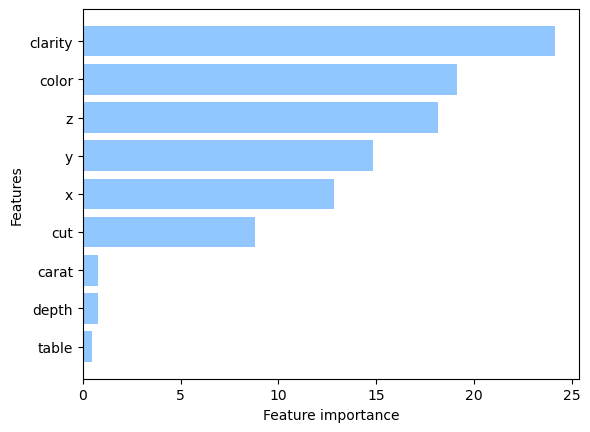

In [295]:
plot_features(data.drop('price', axis=1).columns, catb.feature_importances_)

# Conclusion

> * Best Model - **CatBoostRegressor**
> * Best Parameters - **(default)**
> * Best Achieved Scores: ***{'R2 Score: ': '97.51%',
  'Mean Absolute Error': '323.59',
 'Mean Squared Log Error': '0.02'}***
 
> In my opinion, the most important scoring function to pay attention to in this dataset would be the **Mean Absolute Error**, as we are predicting a price using a regression model, it gives us clear insight on how big the price error is.

> Boban Stevanović 2023